# **Import Libraries**

In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# **Load the data from CSV files**

In [253]:
telemetry_1 = pd.read_csv('telemetry_1.csv')
telemetry_2 = pd.read_csv('telemetry_2.csv')
vehicle_data = pd.read_csv('vehicle_data.csv')

# **Transforming Telemetry 2 Data from long format type to wide format**

In [254]:
telemetry_2_pivot = telemetry_2.pivot_table(index=['vehicle_id', 'timestamp'],
                                            columns='name',
                                            values='val').reset_index()

# **Merging Telemetry Data**

In [255]:
merged_telemetry = pd.merge(telemetry_1, telemetry_2_pivot,
                            on=['vehicle_id', 'timestamp'],
                            how='outer')

# Ensure that data from Telemetry 2 columns is merged into Telemetry 1
for col in telemetry_2_pivot.columns:
    if col not in ['vehicle_id', 'timestamp']:
        if col in merged_telemetry.columns:
            # If column already exists, fill missing values in Telemetry 1 columns with data from Telemetry 2
            merged_telemetry[col].fillna(merged_telemetry[col + '_y'], inplace=True)
            merged_telemetry.drop(columns=[col + '_y'], inplace=True)
        else:
            # If it's a new column from Telemetry 2, add it directly
            merged_telemetry[col] = telemetry_2_pivot[col]

# Drop rows that are fully NaN (optional, depending on the data quality)
merged_telemetry.dropna(how='all', inplace=True)


## **Exploratory Data Analysis (EDA)**

**1. Initial Data Exploration**

In [256]:
print(merged_telemetry.head())

   vehicle_id                         timestamp  speed_x  odometer_x  \
0   vehicle_4         2024-06-06 14:26:23-07:00     64.2         NaN   
1   vehicle_8  2024-07-05 22:24:12.856000-07:00      1.6     12048.0   
2   vehicle_3  2024-06-20 12:57:59.306000-07:00      NaN         NaN   
3  vehicle_10  2024-07-24 18:04:23.776000-07:00     36.2      1434.7   
4  vehicle_11         2024-07-06 11:08:03-07:00     29.5         NaN   

   fuel_level_x  fuel_level_y  odometer_y  speed_y  fuel_level  odometer  \
0           NaN           NaN         NaN      NaN         NaN     466.0   
1           NaN           NaN         NaN      NaN         NaN       NaN   
2          45.0           NaN         NaN      NaN         NaN       NaN   
3           NaN           NaN         NaN      NaN       100.0     466.0   
4           NaN           NaN         NaN      NaN         NaN     466.0   

   speed  
0    NaN  
1    0.0  
2    0.0  
3    NaN  
4    NaN  


In [257]:
print(merged_telemetry.tail())

       vehicle_id                  timestamp  speed_x  odometer_x  \
681102  vehicle_9  2024-08-01 02:59:56+05:30      NaN         NaN   
681103  vehicle_9  2024-08-01 05:25:10+05:30      NaN         NaN   
681104  vehicle_9  2024-08-01 05:25:26+05:30      NaN         NaN   
681105  vehicle_9  2024-08-01 05:26:10+05:30      NaN         NaN   
681106  vehicle_9  2024-08-01 05:28:26+05:30      NaN         NaN   

        fuel_level_x  fuel_level_y  odometer_y  speed_y  fuel_level  odometer  \
681102           NaN           NaN         NaN     26.7         NaN       NaN   
681103           NaN          56.0      6281.0      NaN         NaN       NaN   
681104           NaN           NaN         NaN     18.8         NaN       NaN   
681105           NaN          56.0      6281.0      NaN         NaN       NaN   
681106           NaN           NaN         NaN      0.0         NaN       NaN   

        speed  
681102    NaN  
681103    NaN  
681104    NaN  
681105    NaN  
681106    NaN  


In [258]:
print(merged_telemetry.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681107 entries, 0 to 681106
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vehicle_id    681107 non-null  object 
 1   timestamp     681107 non-null  object 
 2   speed_x       271080 non-null  float64
 3   odometer_x    272566 non-null  float64
 4   fuel_level_x  96559 non-null   float64
 5   fuel_level_y  64599 non-null   float64
 6   odometer_y    180993 non-null  float64
 7   speed_y       180284 non-null  float64
 8   fuel_level    64599 non-null   float64
 9   odometer      180993 non-null  float64
 10  speed         180284 non-null  float64
dtypes: float64(9), object(2)
memory usage: 57.2+ MB
None


**2. Detecting Outliers**

In [269]:
# Function to detect outliers using IQR
def detect_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index

# Detect outliers in speed and fuel level
speed_outliers_idx = detect_outliers_iqr(merged_telemetry, 'speed')
fuel_level_outliers_idx = detect_outliers_iqr(merged_telemetry, 'fuel_level')

# Print the indices of outliers
print("Indices of Speed Outliers:", speed_outliers_idx)
print("Indices of Fuel Level Outliers:", fuel_level_outliers_idx)

Indices of Speed Outliers: Index([ 97363,  56876, 181543, 154148,  18288, 250315,  92389,   5714,  38449,
       156210,
       ...
       109866,  27609, 151108, 167900, 196569, 172656,  35078,  97001, 156765,
        59329],
      dtype='int64', length=143492)
Indices of Fuel Level Outliers: Index([ 97363,  56876, 219451, 154148,  18288, 237538, 228866, 141032, 134468,
       250315,
       ...
       169509,  39649,  76947,  48745,  35078,  97001, 126163, 246642, 255074,
        59329],
      dtype='int64', length=227687)


**3. Visualizing Outliers**

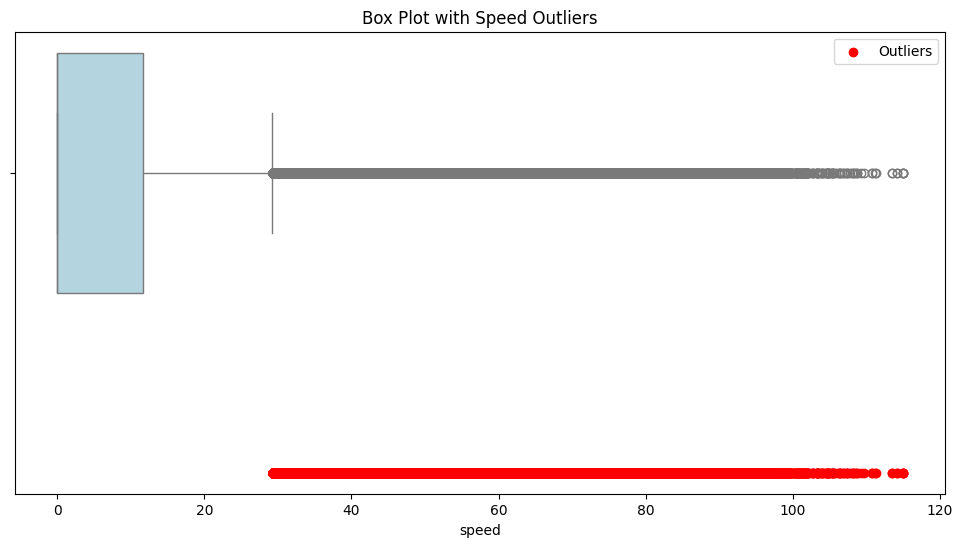

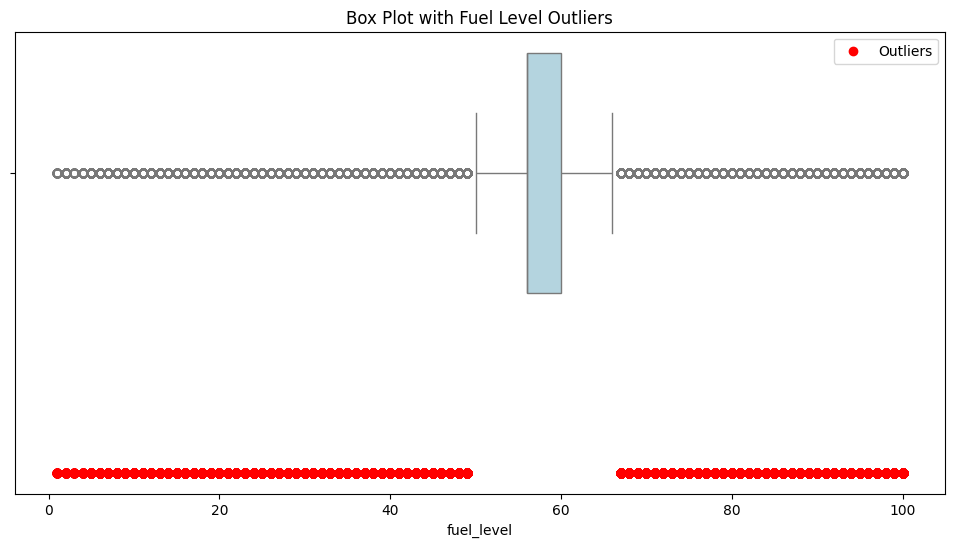

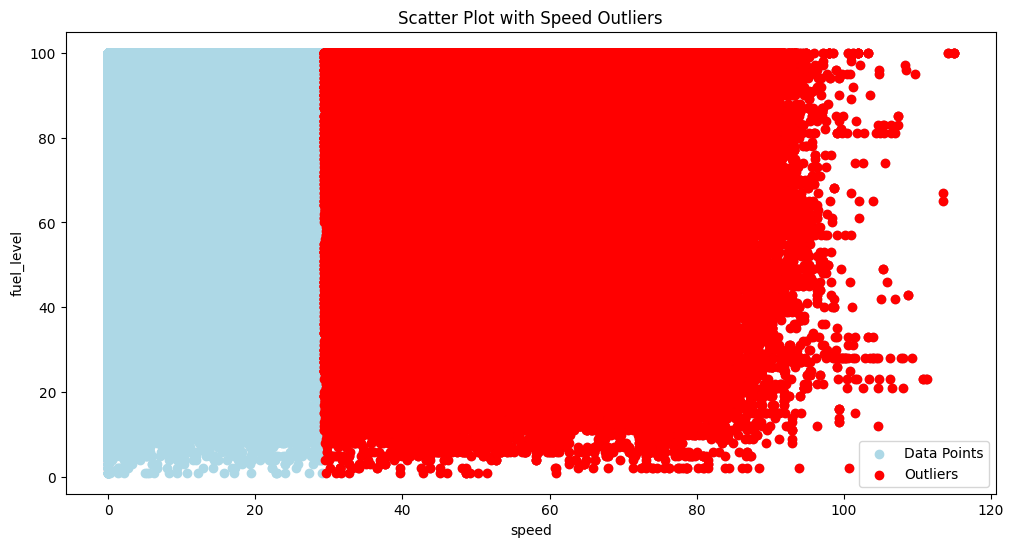

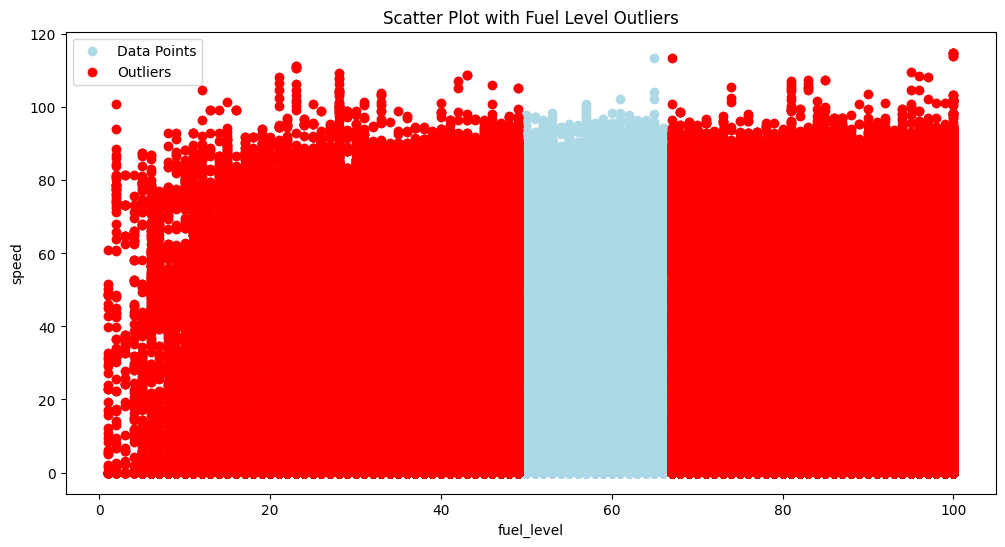

In [270]:
# Plot Box Plot for Speed with Outliers
def plot_boxplot_with_outliers(df, column_name, outlier_indices, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df[column_name], color='lightblue')
    plt.scatter(df.loc[outlier_indices, column_name], [1] * len(outlier_indices), color='red', label='Outliers', zorder=5)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Box Plot for Fuel Level with Outliers
plot_boxplot_with_outliers(merged_telemetry, 'speed', speed_outliers_idx, 'Box Plot with Speed Outliers')
plot_boxplot_with_outliers(merged_telemetry, 'fuel_level', fuel_level_outliers_idx, 'Box Plot with Fuel Level Outliers')

# Optional: Plot Scatter Plot for Speed vs. Fuel Level
def plot_scatter_with_outliers(df, x_column, y_column, outlier_indices, title):
    plt.figure(figsize=(12, 6))
    plt.scatter(df[x_column], df[y_column], color='lightblue', label='Data Points')
    plt.scatter(df.loc[outlier_indices, x_column], df.loc[outlier_indices, y_column], color='red', label='Outliers', zorder=5)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Scatter Plot for Speed vs. Fuel Level with Speed Outliers
plot_scatter_with_outliers(merged_telemetry, 'speed', 'fuel_level', speed_outliers_idx, 'Scatter Plot with Speed Outliers')

# Plot Scatter Plot for Speed vs. Fuel Level with Fuel Level Outliers
plot_scatter_with_outliers(merged_telemetry, 'fuel_level', 'speed', fuel_level_outliers_idx, 'Scatter Plot with Fuel Level Outliers')


# **Handling Missing Values and Anomalies**

In [292]:
# Forward and backward fill for missing values in 'speed', 'odometer', and 'fuel_level'
merged_telemetry['speed'] = merged_telemetry['speed'].ffill().bfill()
merged_telemetry['odometer'] = merged_telemetry['odometer'].ffill().bfill()
merged_telemetry['fuel_level'] = merged_telemetry['fuel_level'].ffill().bfill()

# Drop any rows with remaining NaN values in 'speed', 'odometer', or 'fuel_level'
merged_telemetry.dropna(subset=['speed', 'odometer', 'fuel_level'], inplace=True)

# Optional: Reset index after handling missing values
merged_telemetry.reset_index(drop=True, inplace=True)




In [272]:
merged_telemetry.describe().transpose()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
speed_x,271080.0,3.165517e+01,30.639936,0.0,0.000000,24.900000,62.800000,116.10
odometer_x,272566.0,7.354928e+03,7759.389663,0.0,1988.400000,4582.000000,9818.150000,39059.00
fuel_level_x,96559.0,6.916970e+01,26.552232,1.0,48.000000,73.000000,96.000000,110.00
fuel_level_y,64599.0,6.935999e+01,26.493991,1.0,48.000000,73.000000,96.000000,100.00
odometer_y,180993.0,7.399134e+03,7777.173769,3.0,2029.400000,4587.600000,9901.500000,39061.00
speed_y,180284.0,3.179418e+01,30.738495,0.0,0.000000,25.200000,63.000000,114.90
fuel_level,681107.0,6.095170e+01,17.851973,1.0,56.000000,56.000000,60.000000,100.00
odometer,681107.0,1.072975e+04,8236.597281,51.6,6281.000000,6281.000000,12487.100000,39061.00
speed,681107.0,1.422366e+01,26.448798,0.0,0.000000,0.000000,11.700000,114.90
odometer_diff,681096.0,-6.409331e-02,8696.165358,-38917.0,-781.750000,0.000000,817.950000,38947.00


# **Correlation Analysis**

Correlation Matrix:
               speed  odometer  fuel_level
speed       1.000000  0.362687    0.285162
odometer    0.362687  1.000000    0.180623
fuel_level  0.285162  0.180623    1.000000


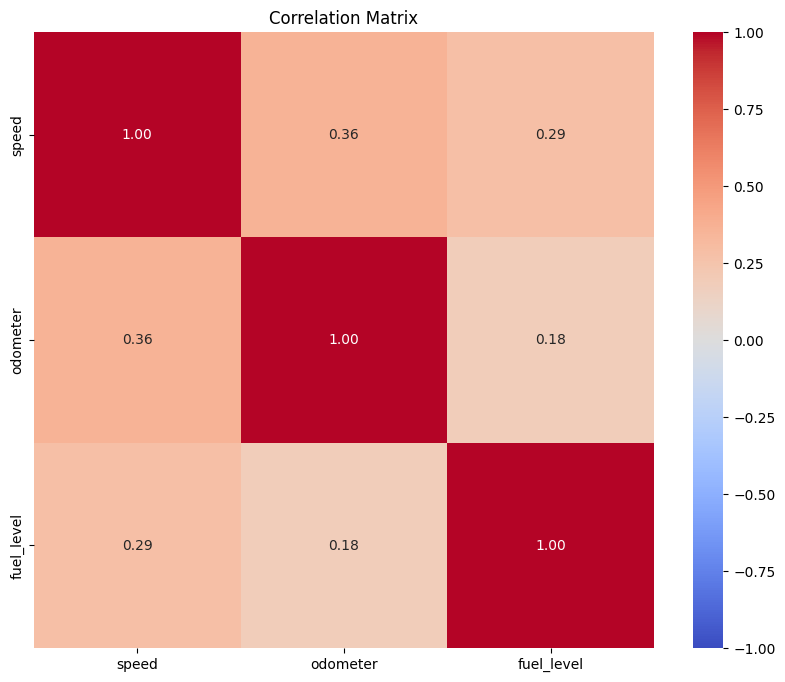

In [273]:
# Compute correlation matrix
correlation_matrix = merged_telemetry[['speed', 'odometer', 'fuel_level']].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# **top 3 takeaways**

In [299]:
# Reset index for a clean DataFrame
merged_telemetry.reset_index(drop=True, inplace=True)

# Explore the dataset - finding the top 3 takeaways
takeaways = {}

# Takeaway 1: Number of unique vehicles
takeaways['unique_vehicles'] = merged_telemetry['vehicle_id'].nunique()

# Takeaway 2: Average speed across all vehicles (handle possible NaNs)
takeaways['average_speed'] = merged_telemetry['speed'].mean()

# Takeaway 3: Average fuel level across all vehicles (handle possible NaNs)
takeaways['average_fuel_level'] = merged_telemetry['fuel_level'].mean()

# Output takeaways
for key, value in takeaways.items():
    print(f"{key}: {value}")

unique_vehicles: 11
average_speed: 14.223664270077974
average_fuel_level: 60.951702155461625


# **calculating Fuel Economy(MPG)**

In [297]:
# Calculate fuel used and distance traveled for each consecutive record
merged_telemetry['fuel_used'] = (merged_telemetry.groupby('vehicle_id')['fuel_level']
                                 .diff().abs() * (merged_telemetry['tank_capacity_vehicle'] / 100))
merged_telemetry['distance_traveled'] = merged_telemetry.groupby('vehicle_id')['odometer'].diff().abs()

# Calculate fuel economy (MPG)
merged_telemetry['fuel_economy_mpg'] = merged_telemetry['distance_traveled'] / merged_telemetry['fuel_used']

# Handle infinite values by replacing them with NaN
merged_telemetry.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dropping rows where calculations cannot be made due to NaN values
fuel_economy_data = merged_telemetry.dropna(subset=['fuel_used', 'distance_traveled', 'fuel_economy_mpg'])

# Extract numeric part of vehicle_id for sorting
fuel_economy_data['vehicle_num'] = fuel_economy_data['vehicle_id'].str.extract('(\d+)').astype(int)

# Group by vehicle_id to get average fuel economy per vehicle and sort by vehicle number
average_fuel_economy = (fuel_economy_data.groupby(['vehicle_id', 'vehicle_num'])['fuel_economy_mpg']
                        .mean().reset_index().sort_values(by='vehicle_num'))

# Drop the auxiliary 'vehicle_num' column
average_fuel_economy.drop(columns=['vehicle_num'], inplace=True)

# Output the average fuel economy in sorted order
print(average_fuel_economy)

# Save the result if needed
average_fuel_economy.to_csv('AverageFuelEconomy.csv', index=False)

    vehicle_id  fuel_economy_mpg
0    vehicle_1       1845.176452
3    vehicle_2       2174.352977
4    vehicle_3       2165.096689
5    vehicle_4       2575.119406
6    vehicle_5       1436.577095
7    vehicle_6       1820.411630
8    vehicle_7       1538.304686
9    vehicle_8       1867.066628
10   vehicle_9       1773.507577
1   vehicle_10       1290.957612
2   vehicle_11       1823.604445


<ipython-input-297-23e054d2222b>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fuel_economy_data['vehicle_num'] = fuel_economy_data['vehicle_id'].str.extract('(\d+)').astype(int)


# **Result**

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'vehicle_1'),
  Text(1, 0, 'vehicle_2'),
  Text(2, 0, 'vehicle_3'),
  Text(3, 0, 'vehicle_4'),
  Text(4, 0, 'vehicle_5'),
  Text(5, 0, 'vehicle_6'),
  Text(6, 0, 'vehicle_7'),
  Text(7, 0, 'vehicle_8'),
  Text(8, 0, 'vehicle_9'),
  Text(9, 0, 'vehicle_10'),
  Text(10, 0, 'vehicle_11')])

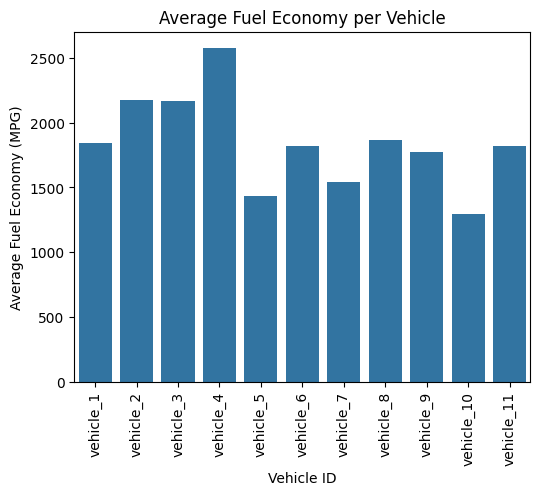

In [298]:
# Plotting
plt.figure(figsize=(20, 10))
# 1. Average Fuel Economy per Vehicle
plt.subplot(2, 3, 1)
sns.barplot(data=average_fuel_economy, x='vehicle_id', y='fuel_economy_mpg')
plt.title('Average Fuel Economy per Vehicle')
plt.xlabel('Vehicle ID')
plt.ylabel('Average Fuel Economy (MPG)')
plt.xticks(rotation=90)